# Prelimaries & Setup


In [1]:
import ast
import os
import random
import tempfile

from nbmetalog import nbmetalog as nbm
import numpy as np
import pandas as pd
from teeplot import teeplot as tp
from tqdm import tqdm
from scipy import stats as scipy_stats
import seaborn as sns


In [2]:
random.seed(1)
np.random.seed(1)


In [3]:
nbm.print_metadata()


context: ci
hostname: fv-az133-456
interpreter: 3.8.10 (default, Mar 13 2023, 10:26:41)  [GCC 9.4.0]
nbcellexec: null
nbname: trait-estimation-error
nbpath: /home/runner/work/phylogeny-informed-evaluation/phylogeny-informed-evaluation/notebooks/trait-estimation-error.ipynb
revision: null
session: 7fd71cdb-ef93-42bd-ace4-06ab75219541
timestamp: 2023-04-30T02:30:03Z00:00


IPython==8.12.1
keyname==0.5.2
yaml==5.3.1
nbmetalog==0.2.6
numpy==1.24.3
pandas==2.0.1
scipy==1.10.1
seaborn==0.12.2
teeplot==0.5.0
re==2.2.1
comm==0.1.3
logging==0.5.1.2
psutil==5.9.5
zmq==25.0.2
json==2.0.9
ipykernel==6.22.0


# Fetch Data


In [4]:
df = pd.read_csv("https://osf.io/45b6h/download", compression="gzip")
df


,id,ancestor_list,origin_time,destruction_time,num_orgs,tot_orgs,num_offspring,total_offspring,depth,fitness,...,traits_successful_estimations,traits_estimation_source_ids,traits_estimation_dist,traits_estimated_scores,update,EVAL_MODE,TEST_DOWN_SAMPLE_RATE,DIAGNOSTIC,EVAL_FIT_EST_MODE,run
0,252599,[252209],1000,inf,1,1,0,0,530,NaN,...,[],[],[],[],1000,cohort,0.5,multipath-exploration,ancestor-opt,RUN_C44_2221
1,252594,[252188],1000,inf,1,1,0,0,550,NaN,...,[],[],[],[],1000,cohort,0.5,multipath-exploration,ancestor-opt,RUN_C44_2221
2,252593,[251988],1000,inf,1,1,0,0,548,NaN,...,[],[],[],[],1000,cohort,0.5,multipath-exploration,ancestor-opt,RUN_C44_2221
3,252592,[252068],1000,inf,1,1,0,0,512,NaN,...,[],[],[],[],1000,cohort,0.5,multipath-exploration,ancestor-opt,RUN_C44_2221
4,252588,[252137],1000,inf,1,1,0,0,545,NaN,...,[],[],[],[],1000,cohort,0.5,multipath-exploration,ancestor-opt,RUN_C44_2221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349184,5047503,[5046860],19998,inf,1,2,0,0,10120,99.9983,...,"[0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,1...","[0,0,5046860,0,0,0,0,0,5047503,5047503,0,50468...","[0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1...","[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0...",20000,cohort,0.5,contradictory-objectives,relative-opt,RUN_C31_2156
349185,5047957,[5047281],20000,inf,1,1,0,0,10109,NaN,...,[],[],[],[],20000,cohort,0.5,contradictory-objectives,relative-opt,RUN_C31_2156
349186,5047902,[5046576],20000,inf,1,1,0,0,10137,NaN,...,[],[],[],[],20000,cohort,0.5,contradictory-objectives,relative-opt,RUN_C31_2156
349187,5047348,[5047059],19998,inf,1,2,0,0,10087,99.9998,...,"[0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,1...","[0,0,5047059,0,0,0,0,0,5047348,5047348,0,50470...","[0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1...","[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0...",20000,cohort,0.5,contradictory-objectives,relative-opt,RUN_C31_2156


In [5]:
dfdigest = np.bitwise_xor.reduce(
    pd.util.hash_pandas_object(df),
)
print("{:x}".format(dfdigest))


f8f17abcb5445d38


In [6]:
# subset data to keep exploratory analyses tractable
# df = df[(df["update"] == 20000) & (df["TEST_DOWN_SAMPLE_RATE"] == 0.5)]
df = df[(df["update"] == 20000)]
df = df.sample(frac=0.1)


# Convert Data Vectors to Long-Form

i.e., each trait of each individual is a single row


In [7]:
vector_columns = (
    #     "genome",
    "phenotype",
    "traits_attempted_estimations",
    "traits_estimation_dist",
    "traits_estimated_scores",
    "traits_estimation_source_ids",
    "traits_evaluated",
    "traits_successful_estimations",
)


In [8]:
for column in tqdm(vector_columns):
    print(column)
    df[column] = df[column].apply(ast.literal_eval)


  0%|          | 0/7 [00:00<?, ?it/s]

phenotype


 14%|█▍        | 1/7 [00:01<00:08,  1.35s/it]

traits_attempted_estimations


 29%|██▊       | 2/7 [00:02<00:06,  1.33s/it]

traits_estimation_dist


 43%|████▎     | 3/7 [00:04<00:05,  1.35s/it]

traits_estimated_scores


 57%|█████▋    | 4/7 [00:05<00:03,  1.32s/it]

traits_estimation_source_ids


 71%|███████▏  | 5/7 [00:06<00:02,  1.31s/it]

traits_evaluated


 86%|████████▌ | 6/7 [00:08<00:01,  1.35s/it]

traits_successful_estimations


100%|██████████| 7/7 [00:09<00:00,  1.33s/it]


In [9]:
df["vector len"] = df["traits_evaluated"].apply(len)
for column in tqdm(vector_columns):
    print(column)
    assert (df[column].apply(len) == df["vector len"]).all()


100%|██████████| 7/7 [00:00<00:00, 237.35it/s]

phenotype
traits_attempted_estimations
traits_estimation_dist
traits_estimated_scores
traits_estimation_source_ids
traits_evaluated
traits_successful_estimations


In [10]:
df["vector index"] = df["vector len"].apply(lambda x: [*range(x)])


In [11]:
df["num traits evaluated"] = df["traits_evaluated"].apply(sum)
df["num attempted trait estimations"] = df["traits_attempted_estimations"].apply(sum)
df["num successful trait estimations"] = df["traits_successful_estimations"].apply(sum)


In [12]:
(df["num successful trait estimations"] == df["num attempted trait estimations"]).all()


True

In [13]:
# chunk to prevent running out of memory
chunk_size = 32768
num_chunks = (len(df) + chunk_size - 1) // chunk_size

exploded_chunks = []
for i in tqdm(range(num_chunks)):
    start_idx = i * chunk_size
    end_idx = min((i + 1) * chunk_size, len(df))
    chunk = df.iloc[start_idx:end_idx]

    exploded_chunk = chunk.explode(["vector index", *vector_columns])
    exploded_chunks.append(exploded_chunk)


100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


In [14]:
# concatenate chunks to single csv, delete from memory, then reload from csv
with tempfile.NamedTemporaryFile(mode="w") as tmpfile:
    for i, exploded_chunk in enumerate(tqdm(exploded_chunks)):
        kwargs = {"index": False, "chunksize": 4096}
        if i:
            kwargs["mode"] = "a"
            kwargs["header"] = False
        exploded_chunk.to_csv(tmpfile.name, **kwargs)
        tmpfile.flush()

    del exploded_chunks
    exploded_df = pd.read_csv(tmpfile.name)

exploded_df


100%|██████████| 1/1 [00:23<00:00, 23.26s/it]


,id,ancestor_list,origin_time,destruction_time,num_orgs,tot_orgs,num_offspring,total_offspring,depth,fitness,...,EVAL_MODE,TEST_DOWN_SAMPLE_RATE,DIAGNOSTIC,EVAL_FIT_EST_MODE,run,vector len,vector index,num traits evaluated,num attempted trait estimations,num successful trait estimations
0,5049499,[5049240],20000,inf,1,1,0,0,10127,NaN,...,down-sample,0.5,contradictory-objectives,none,RUN_C1_2006,0,NaN,0,0,0
1,5047569,[5047074],20000,inf,1,1,0,0,13017,NaN,...,down-sample,0.5,exploitation-rate,relative-opt,RUN_C3_2019,0,NaN,0,0,0
2,5045903,[5045567],19999,inf,2,2,0,0,10987,2215.20,...,cohort,0.5,multipath-exploration,none,RUN_C38_2194,100,0.0,20,0,0
3,5045903,[5045567],19999,inf,2,2,0,0,10987,2215.20,...,cohort,0.5,multipath-exploration,none,RUN_C38_2194,100,1.0,20,0,0
4,5045903,[5045567],19999,inf,2,2,0,0,10987,2215.20,...,cohort,0.5,multipath-exploration,none,RUN_C38_2194,100,2.0,20,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1080385,5043938,[5043210],19997,inf,1,3,3,4,10647,1571.44,...,cohort,0.5,multipath-exploration,relative-opt,RUN_C50_2254,100,95.0,27,90,90
1080386,5043938,[5043210],19997,inf,1,3,3,4,10647,1571.44,...,cohort,0.5,multipath-exploration,relative-opt,RUN_C50_2254,100,96.0,27,90,90
1080387,5043938,[5043210],19997,inf,1,3,3,4,10647,1571.44,...,cohort,0.5,multipath-exploration,relative-opt,RUN_C50_2254,100,97.0,27,90,90
1080388,5043938,[5043210],19997,inf,1,3,3,4,10647,1571.44,...,cohort,0.5,multipath-exploration,relative-opt,RUN_C50_2254,100,98.0,27,90,90


# Setup New Columns needed for Analyses


In [15]:
len(exploded_df)


1080390

## Raw Trait Error


In [16]:
exploded_df["trait estimation error"] = (
    exploded_df["phenotype"] - exploded_df["traits_estimated_scores"]
)
exploded_df["trait estimation abs error"] = exploded_df["trait estimation error"].abs()


## Normalized Trait Values


In [17]:
groupby_columns = [
    "EVAL_MODE",
    "TEST_DOWN_SAMPLE_RATE",
    "DIAGNOSTIC",
    "EVAL_FIT_EST_MODE",
    "vector index",
    "update",
]
exploded_df["normalized phenotype"] = exploded_df.groupby(
    groupby_columns,
)["phenotype"].rank(pct=True)


def add_normalized_trait_estimate(df: pd.DataFrame) -> pd.DataFrame:
    df["normalized trait estimate"] = scipy_stats.percentileofscore(
        a=df["phenotype"],
        score=df["traits_estimated_scores"],
    ) / 100
    return df
exploded_df = exploded_df.groupby(
    groupby_columns,
    group_keys=False,
).apply(
    add_normalized_trait_estimate,
)


In [18]:
exploded_df["normalized trait estimation error"] = (
    exploded_df["normalized phenotype"]
    - exploded_df["normalized trait estimate"]
)
exploded_df["abs normalized trait estimation error"] = (
    exploded_df["normalized trait estimation error"].abs()
)


## Trait Estimation Outcome


In [19]:
exploded_df["is evaluated"] = exploded_df["traits_evaluated"] == 1
exploded_df["is evaluated"].sum()


397122

In [20]:
exploded_df["is attempted estimation"] = (
    exploded_df["traits_attempted_estimations"] == 1
)
exploded_df["is attempted estimation"].sum()


555010

In [21]:
exploded_df["is successful estimation"] = (
    exploded_df["traits_successful_estimations"] == 1
)
exploded_df["is successful estimation"].sum()


555010

In [22]:
exploded_df["is failed estimation"] = (
    exploded_df["is attempted estimation"]
    & ~exploded_df["is successful estimation"]
)
exploded_df["is failed estimation"].sum()


0

In [23]:
assert not (
    exploded_df["is successful estimation"] & exploded_df["is failed estimation"]
).any()


In [24]:
exploded_df["estimation outcome"] = "na"
exploded_df.loc[
    exploded_df["is failed estimation"],
    "estimation outcome",
] = "failed"
exploded_df.loc[
    exploded_df["is successful estimation"],
    "estimation outcome",
] = "successful"


# Plot: estimation mode vs estimation failure


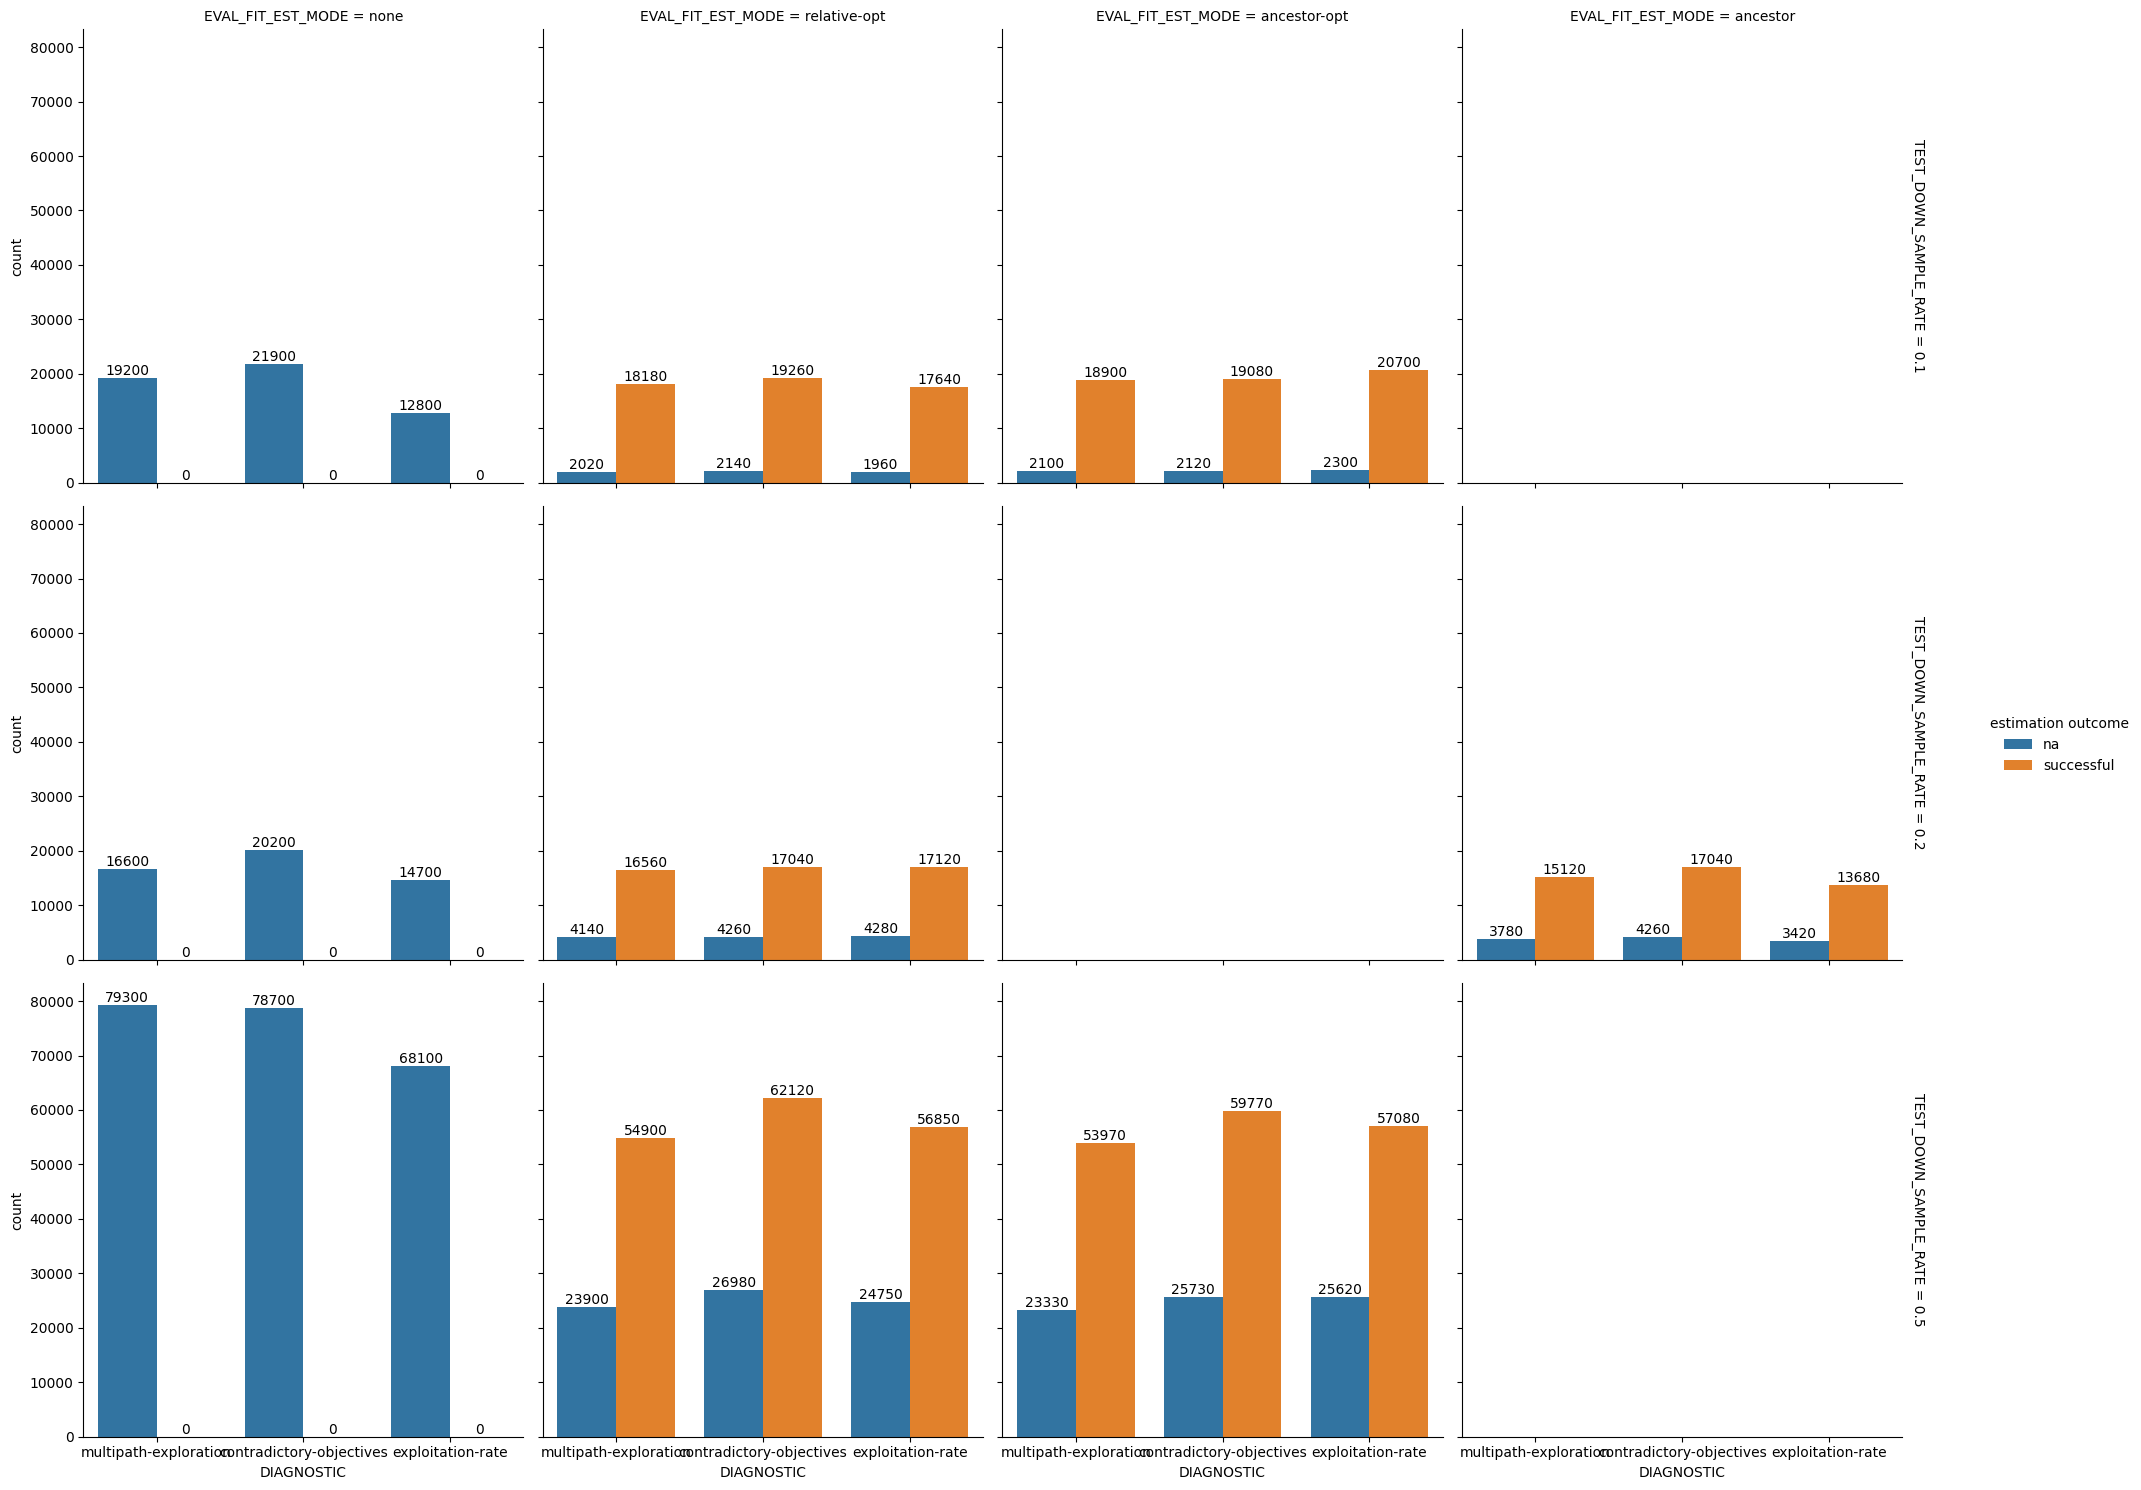

In [25]:
g = sns.catplot(
    exploded_df,
    col="EVAL_FIT_EST_MODE",
    row="TEST_DOWN_SAMPLE_RATE",
    x="DIAGNOSTIC",
    hue="estimation outcome",
    kind="count",
    margin_titles=True,
)
for ax in g.axes.flat:
    for container in ax.containers:
        ax.bar_label(container, label_type='edge')


# Plot: estimated score vs phenotype

by diagnostic and estimate mode


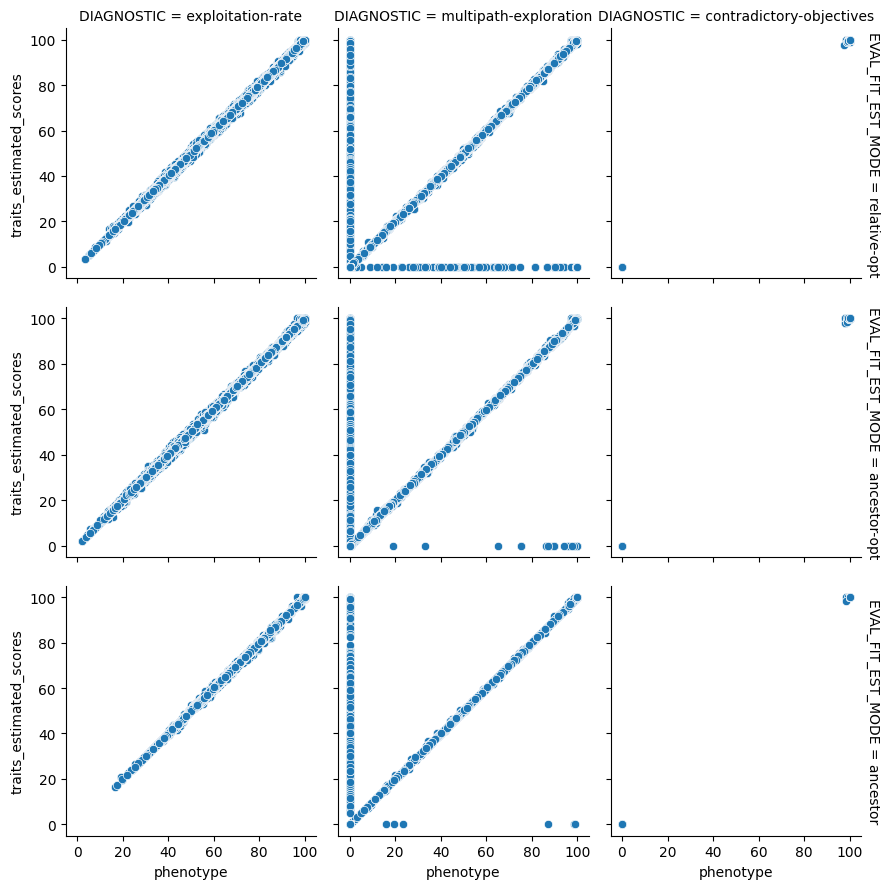

In [26]:
g = sns.FacetGrid(
    exploded_df[
        #         :
        exploded_df["is successful estimation"]
    ],
    col="DIAGNOSTIC",
    row="EVAL_FIT_EST_MODE",
    margin_titles=True,
)
g.map(
    sns.scatterplot,
    "phenotype",
    "traits_estimated_scores",
)


# Plot: trait estimation error vs phylogenetic distance

for each diagnostic and estimation mode


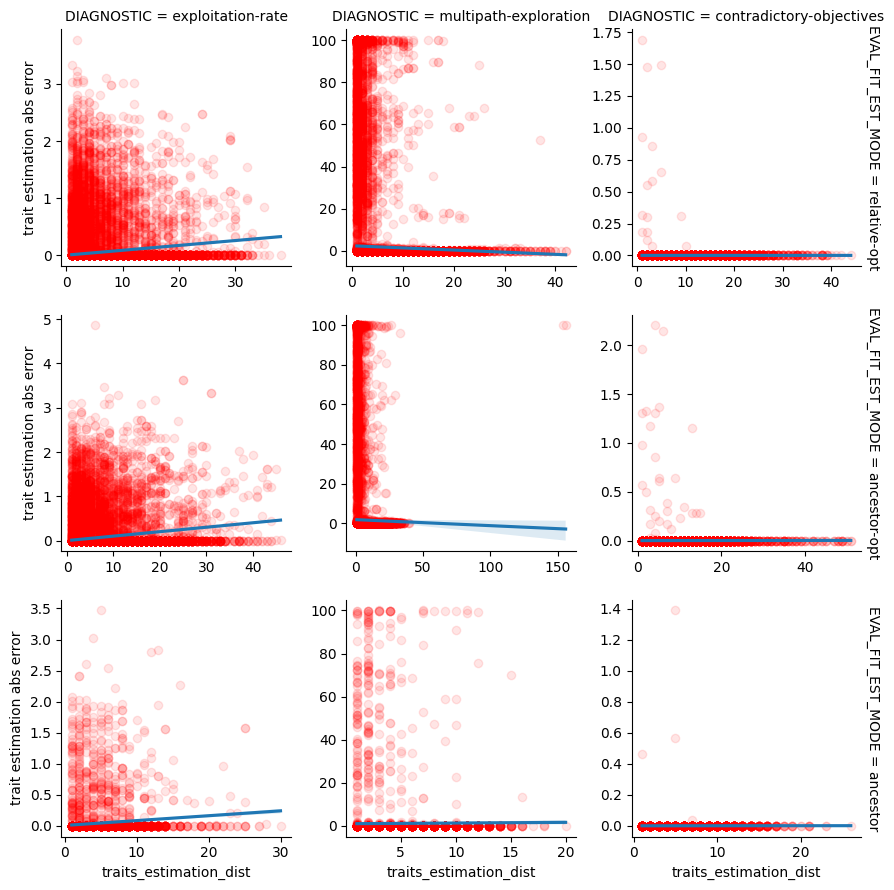

In [27]:
g = sns.FacetGrid(
    exploded_df[
        #         :
        exploded_df["is successful estimation"]
        & (exploded_df["traits_estimation_dist"] > 0)
    ],
    col="DIAGNOSTIC",
    row="EVAL_FIT_EST_MODE",
    margin_titles=True,
    sharex=False,
    sharey=False,
)
g.map(
    sns.regplot,
    "traits_estimation_dist",
    "trait estimation abs error",
    n_boot=10,
    scatter_kws={
        "color": "red",
        "alpha": 0.1,
    },
)


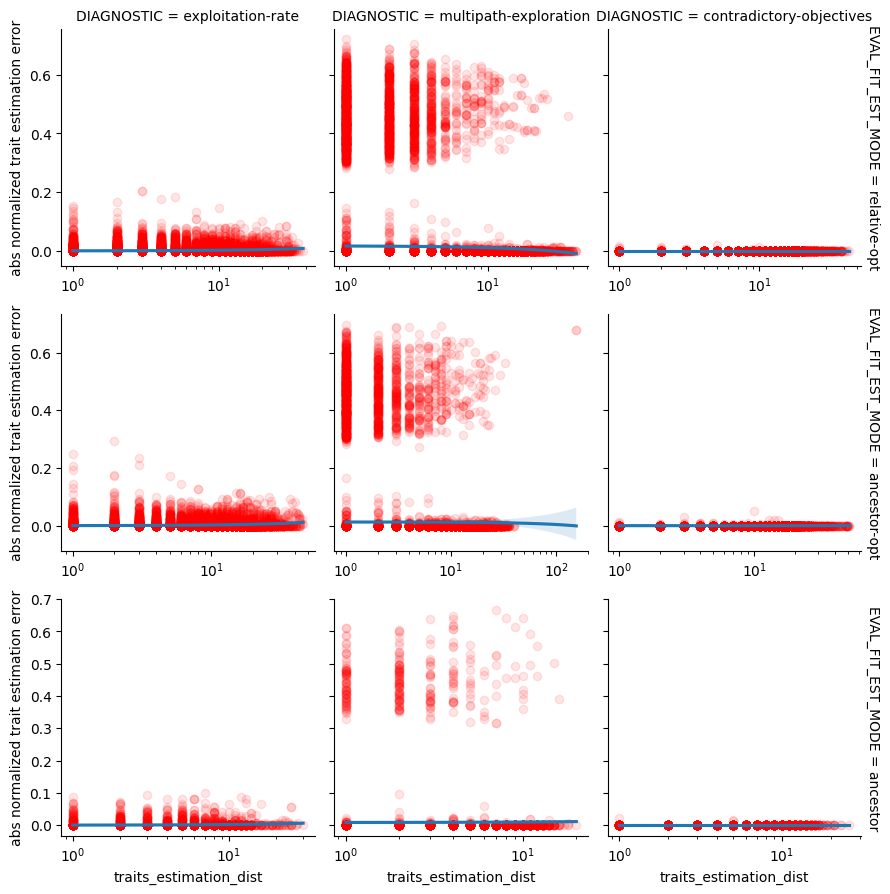

In [28]:
g = sns.FacetGrid(
    exploded_df[
        exploded_df["is successful estimation"]
        & (exploded_df["traits_estimation_dist"] > 0)
    ],
    col="DIAGNOSTIC",
    row="EVAL_FIT_EST_MODE",
    margin_titles=True,
    sharex=False,
    sharey="row",
)
g.map(
    sns.regplot,
    "traits_estimation_dist",
    "abs normalized trait estimation error",
    n_boot=10,
    scatter_kws={
        "color": "red",
        "alpha": 0.1,
    },
).set(
    xscale="log",
)


# Plot: mean estimation error by diagnostic/estimation mode


/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


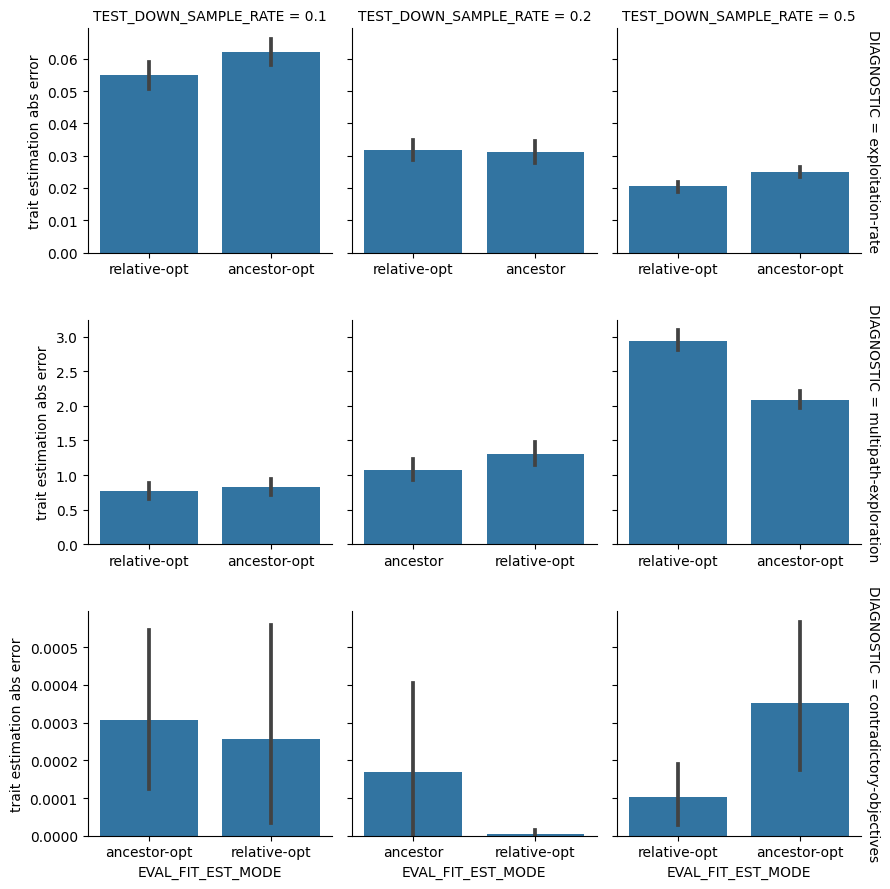

In [29]:
g = sns.FacetGrid(
    exploded_df[
        #         :
        exploded_df["is successful estimation"]
        & (exploded_df["traits_estimation_dist"] > 0)
    ],
    row="DIAGNOSTIC",
    col="TEST_DOWN_SAMPLE_RATE",
    margin_titles=True,
    sharey="row",
    sharex=False,
)
g.map(
    sns.barplot,
    "EVAL_FIT_EST_MODE",
    "trait estimation abs error",
)


/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


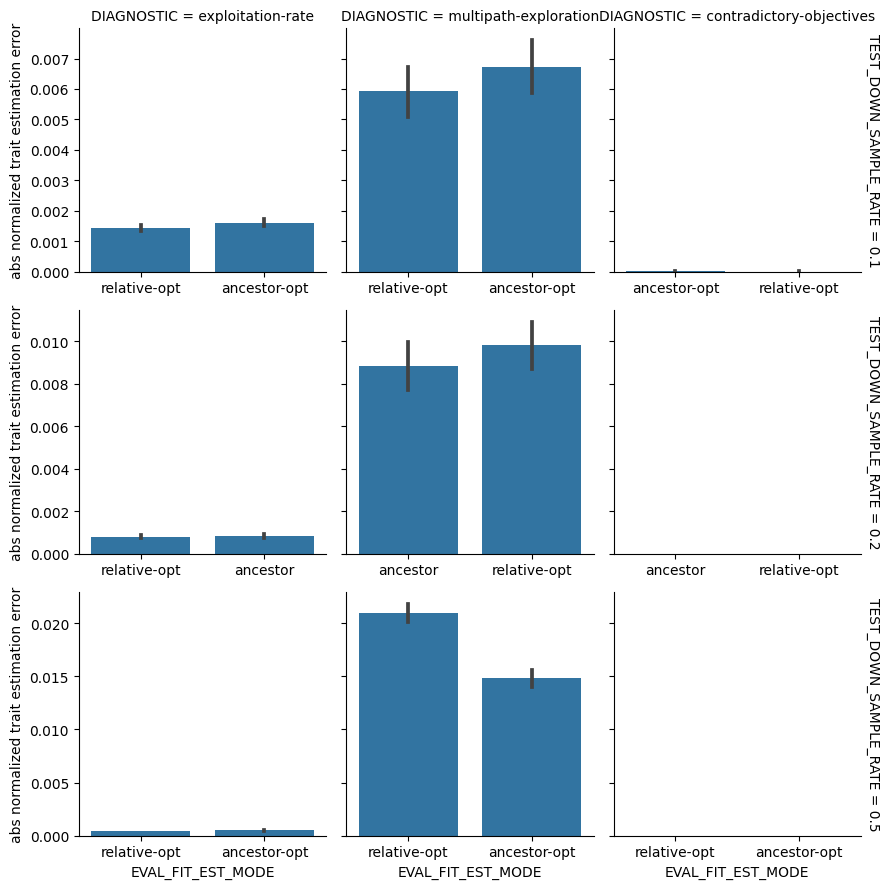

In [30]:
g = sns.FacetGrid(
    exploded_df[
        exploded_df["is successful estimation"]
        & (exploded_df["traits_estimation_dist"] > 0)
    ],
    col="DIAGNOSTIC",
    row="TEST_DOWN_SAMPLE_RATE",
    margin_titles=True,
    sharey="row",
    sharex=False,
)
g.map(
    sns.barplot,
    "EVAL_FIT_EST_MODE",
    "abs normalized trait estimation error",
)


# Plot: phylogenetic estimation distance by diagnostic/estimation mode


/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


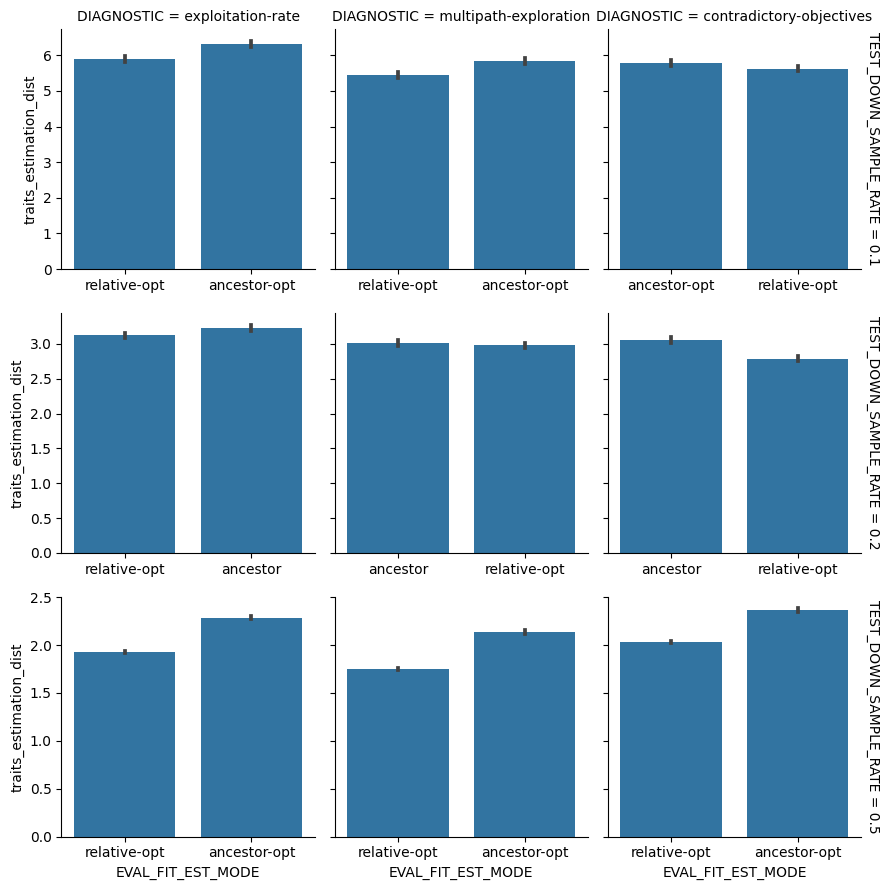

In [31]:
g = sns.FacetGrid(
    exploded_df[
        #         :
        exploded_df["is successful estimation"]
        & (exploded_df["traits_estimation_dist"] > 0)
    ],
    col="DIAGNOSTIC",
    row="TEST_DOWN_SAMPLE_RATE",
    margin_titles=True,
    sharey="row",
    sharex=False,
)
g.map(
    sns.barplot,
    "EVAL_FIT_EST_MODE",
    "traits_estimation_dist",
)


# Plot: error distributions

by diagnostic/evaluation mode


/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


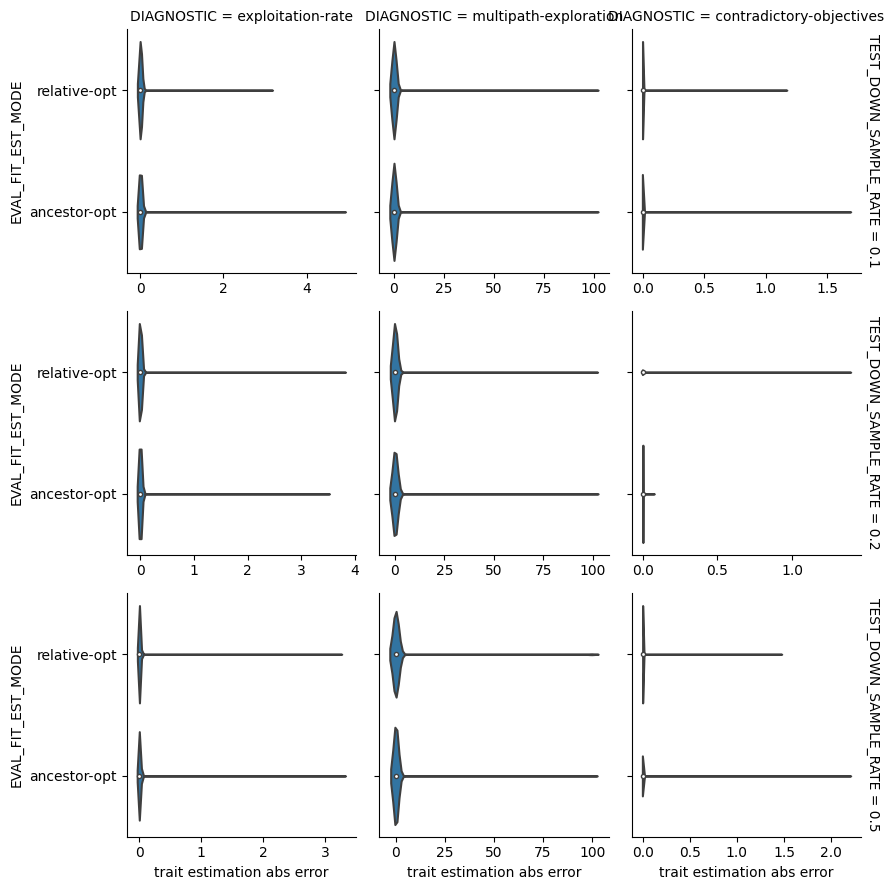

In [32]:
g = sns.FacetGrid(
    exploded_df[exploded_df["is successful estimation"]],
    col="DIAGNOSTIC",
    row="TEST_DOWN_SAMPLE_RATE",
    margin_titles=True,
    sharex=False,
)
g.map(
    sns.violinplot,
    "trait estimation abs error",
    "EVAL_FIT_EST_MODE",
)


/home/runner/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


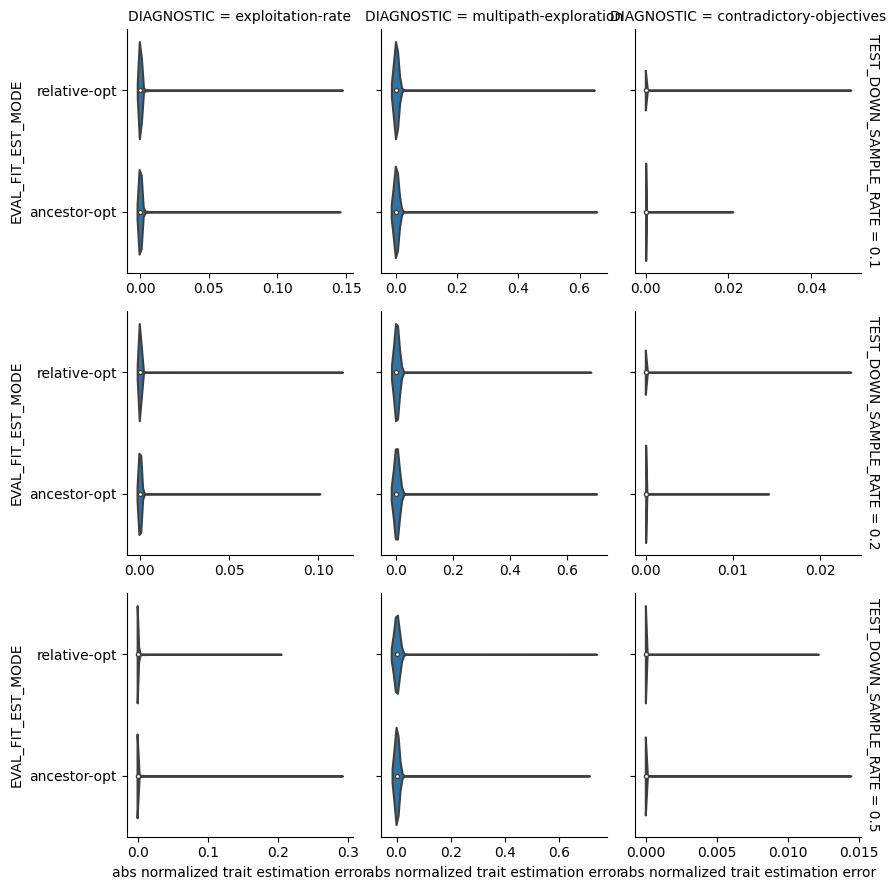

In [33]:
g = sns.FacetGrid(
    exploded_df[exploded_df["is successful estimation"]],
    col="DIAGNOSTIC",
    row="TEST_DOWN_SAMPLE_RATE",
    margin_titles=True,
    sharex=False,
)
g.map(
    sns.violinplot,
    "abs normalized trait estimation error",
    "EVAL_FIT_EST_MODE",
)


# Statistics (TODO)


In [34]:
groupby_columns = [
    "EVAL_MODE",
    "TEST_DOWN_SAMPLE_RATE",
    "DIAGNOSTIC",
    "EVAL_FIT_EST_MODE",
    "update",
]
for group, group_df in exploded_df.groupby(groupby_columns):
    group_attrs = dict(zip(groupby_columns, group))
    print(group_attrs)


{'EVAL_MODE': 'cohort', 'TEST_DOWN_SAMPLE_RATE': 0.5, 'DIAGNOSTIC': 'contradictory-objectives', 'EVAL_FIT_EST_MODE': 'ancestor-opt', 'update': 20000}
{'EVAL_MODE': 'cohort', 'TEST_DOWN_SAMPLE_RATE': 0.5, 'DIAGNOSTIC': 'contradictory-objectives', 'EVAL_FIT_EST_MODE': 'none', 'update': 20000}
{'EVAL_MODE': 'cohort', 'TEST_DOWN_SAMPLE_RATE': 0.5, 'DIAGNOSTIC': 'contradictory-objectives', 'EVAL_FIT_EST_MODE': 'relative-opt', 'update': 20000}
{'EVAL_MODE': 'cohort', 'TEST_DOWN_SAMPLE_RATE': 0.5, 'DIAGNOSTIC': 'exploitation-rate', 'EVAL_FIT_EST_MODE': 'ancestor-opt', 'update': 20000}
{'EVAL_MODE': 'cohort', 'TEST_DOWN_SAMPLE_RATE': 0.5, 'DIAGNOSTIC': 'exploitation-rate', 'EVAL_FIT_EST_MODE': 'none', 'update': 20000}
{'EVAL_MODE': 'cohort', 'TEST_DOWN_SAMPLE_RATE': 0.5, 'DIAGNOSTIC': 'exploitation-rate', 'EVAL_FIT_EST_MODE': 'relative-opt', 'update': 20000}
{'EVAL_MODE': 'cohort', 'TEST_DOWN_SAMPLE_RATE': 0.5, 'DIAGNOSTIC': 'multipath-exploration', 'EVAL_FIT_EST_MODE': 'ancestor-opt', 'update